In [36]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys
from scipy import stats
%matplotlib inline

#Problem specific libarires:
import scipy.signal as sig
import Pendulum_Module as pm

sys.path.append('/Users/Daniel Fogh/Desktop/MAIN_(BU_25-07-22)/BSc_Samlet/3. Year/AppStat/AppStat_Code')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

Importing and partitioning data

In [37]:
#Importing period data-files:
names = ['chamilla', 'daniel', 'emil', 'julius', 'sejr']

#Creating dictionary of all data (MIGHT NOT BE THE BEST WAY TO IMPORT THE DATA)
N_dict={}
t_dict={}

for i, name in enumerate(names):
    data = np.genfromtxt(str(name)+'.dat', delimiter='', skip_header=0, skip_footer=0, dtype=float)
    N, t = data[:, 0], data[:, 1]
    N, t = N[N<26], t[N<26] #Including only the 25 first measurements                                   
    N_dict["{0}".format(i+1)] = N
    t_dict["{0}".format(i+1)] = t

In [38]:
#Length data
#Combined mesurements before and after the experiment, to account for string-stretching
l_data = np.array([182.1, 183.6, 182.2, 186.6, 183.6, 183.9, 182.1, 182.9, 182.4, 182.6])*1E-2  #SI conversion factor, measured in cm
h_data = np.array([60.7, 61.0, 61.6, 61.4, 61.5])*(1E-3/2)  #measured in mm, divided by 2 as we measured diameter
ls_data = np.array([0.5, 0.5, 0.5, 0.5, 0.8, 1.0, 0.3, 0.5, 0.5, 0.5])*1E-2 #measured in cm
hs_data = np.array([0.05, 0.05, 0.05, 0.05, 0.05])*((1E-2)/2)   #measured in mm, divided by 2 as we measured diameter

#NOTE: I've not included Length measurements done with the old hierloom ruler.

[0.005 0.005 0.005 0.005 0.008 0.01  0.003 0.005 0.005 0.005]


Combining measurements to get $L\pm \sigma_L$ for entire group. Since $l$ and $h$ measurement-arrays don't have same size, we take the weighted mean of all measurements first and then calculate $L$. If $\chi^2$ is very big, $p$ will be very small, and this indicates our uncertainties are waaay underestimated. for $l$, only multiplying our errors by a factor 40 brought the values up to a acceptable level.

In [39]:
#Performing weighted means:
l, l_err, *l_chi = pm.wmean(l_data, ls_data)
h, h_err, *h_chi = pm.wmean(h_data, hs_data)

L = l+h
L_err = np.sqrt(l_err**2 + h_err**2) #By error-propagation

print('l weighted', l, l_err, l_chi)
print('h weighted', h, h_err, h_chi)
print('L =', L, L_err)

l weighted 1.8293851024829195 0.0015490642551732828 [71.41493251124804, 8.033176590422566e-12]
h weighted 0.03062 0.00011180339887498949 [2.2879999999999936, 0.6829546930721826]
L = 1.8600051024829196 0.0015530937082660393


    Comment: Error on L seems way to low.

Finding the period through fitting; this procedure is to be repeated seperately for each of the 5 measurement-series. Afterwards, the 5 estimates gets combined through a weighted mean to a single measurement $T\pm\sigma_T$ to be used to find $g$.

    Comment: (N,t) data-files do not start at the same time!

In [40]:
#Defining universal functions:
#Defining T-fit
def T_func(N,T,t0):
    return T*N+t0

#Define chi2 for T-fit
def chi2_T(N,t,ts,T,t0) : #Note: must not be a function of x
    y_fit = T_func(N,T,t0)
    chi2 = np.sum(((t - y_fit) / ts)**2)
    return chi2

#Define gaussian
def gauss(x, A, mu, sigma):
    z = (x - mu) / sigma
    return A*(np.sqrt(2*np.pi)*sigma)**(-1) * np.exp(-0.5 * z**2)

#Define chi2 for gaussian
def chi2_gauss(x, y, sy, A, mu, sigma) :
    y_fit = gauss(x, A, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

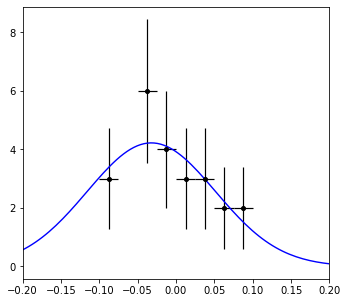

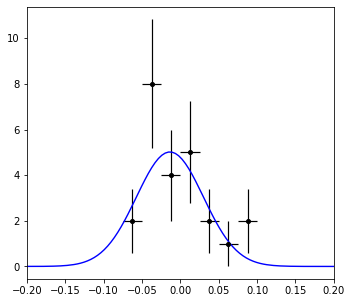

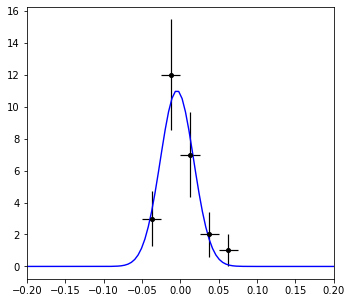

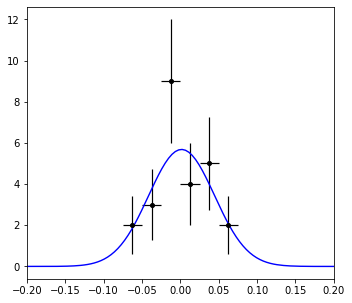

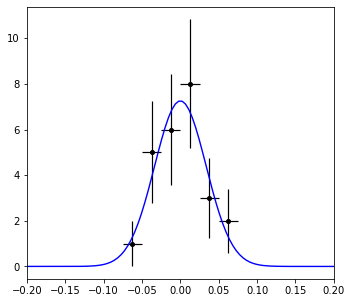

In [41]:
numbers = ['1','2','3','4','5']

#Defining container arrays
chi2_array = []
p_array = []
T_array = []
Terr_array = []

#We make a loop that does the fitting and whatnot to find T for every dataset.
for i, nr in enumerate(numbers):
    N, t = N_dict[nr], t_dict[nr] #Select a dataset

    ts = 1 #Initial error on datapoints
    miniobj = lambda T,t0: chi2_T(N,t,ts,T,t0) #Define a object to minimze

    #Fitting
    miniobj.errordef = Minuit.LEAST_SQUARES
    minuit_fit1 = Minuit(miniobj, T=3, t0=10)     
    minuit_fit1.migrad()                            

    #Extracting fit-parameters:
    #print('For first fit, run', i+1)
    #pm.printnice(minuit_fit1, N)

    #Calculating residuals:
    t_fit = T_func(N, *minuit_fit1.values) #Calculating expected times according to previous fit
    res = t-t_fit                          #Calculating residuals

    #Extracting data-points with error-bars from binned data, so we can fit a gaussian to residuals


    xmin, xmax, bins = -0.1,0.1, 8 
    counts, bin_edges = np.histogram(res, bins=bins,  range=(xmin,xmax), density=False)
    res_x = 0.5*(bin_edges[:-1] + bin_edges[1:])[counts>0] 
    res_y = counts[counts>0]       
    res_sx = (bin_edges[1]-bin_edges[0])*0.5 #The binwidth
    res_sy = np.sqrt(res_y) #Poisson error

    #Fitting a gaussian to the residual-histogram
    #Define a object to minimze
    miniobj2 = lambda A, mu, sigma: chi2_gauss(res_x, res_y, res_sy, A, mu, sigma)

    #Fitting
    miniobj2.errordef = Minuit.LEAST_SQUARES
    minuit_fit2 = Minuit(miniobj2, A=0.1, mu=np.mean(res), sigma=np.std(res))
    minuit_fit2.migrad()       

    #Extracting fit-parameters:
    #print('For second fit, run', i+1)
    #pm.printnice(minuit_fit2, res_x)

   #Plotting our fit just to double-check
    res_x_fit = np.linspace(xmin-1, xmax+1, 500)
    res_y_fit = gauss(res_x_fit, *minuit_fit2.values)

    fig, ax = plt.subplots(figsize=(5.5,5))
    plt.errorbar(res_x, res_y , yerr=res_sy, xerr=res_sx, fmt='k.', elinewidth=1.2, ms=8)
    plt.plot(res_x_fit, res_y_fit, c='b', lw=1.4)
    plt.xlim(-0.2,0.2)

    #Performing period-fit again, but with new uncertanties:
    ts = minuit_fit2.values[2]
    miniobj3 = lambda T,t0: chi2_T(N,t,ts,T,t0)
    miniobj3.errordef = Minuit.LEAST_SQUARES
    minuit_fit3 = Minuit(miniobj3, T=7, t0=10)     
    minuit_fit3.migrad()                            

    #Extracting fit-parameters:
    #print('For third fit, run', i+1)
    #pm.printnice(minuit_fit3, N)
    #print(minuit_fit3.parameters[0], minuit_fit3.values[0], minuit_fit3.errors[0])

    Chi2_value = minuit_fit3.fval
    Ndof = len(N) - len(minuit_fit3.values[:])
    Chi2_prob = stats.chi2.sf(Chi2_value, Ndof) 

    chi2_array.append(Chi2_value)
    p_array.append(Chi2_prob)
    T_array.append(minuit_fit3.values[0])
    Terr_array.append(minuit_fit3.errors[0])

In [42]:
print(chi2_array)
print(p_array)
print(T_array)
print(Terr_array)

[14.492817428991, 29.777230263714618, 24.917795313173894, 13.4304617631536, 27.582606977256862]
[0.9118856791539577, 0.15590406962437656, 0.35453775026696244, 0.9420294052035226, 0.23197797284115015]
[2.735021999999712, 2.7345657692307577, 2.735546615383573, 2.7346213846151732, 2.7344519999990373]
[0.0023207004033168883, 0.0012113150629655346, 0.0006015999135440436, 0.0011900049264198353, 0.0009315634705966769]


Comments: something goes wrong at histogram fitting; automizae this.
use sample mean as estimator

In [47]:
T, T_err, *info = pm.wmean(np.array(T_array),np.array(Terr_array))
print('T (weighted)', T, T_err)
print('T (arithmatic)', np.mean(T_array), np.std(T_array))

T (weighted) 2.735058231632791 0.00042683948164842854
T (arithmatic) 2.7348415538456505 0.0004014863459806906


In [44]:
def g(T,L):
 return L*(2*np.pi/T)**2

def gerr(T, L, Terr, Lerr):
    return np.sqrt(  (64*(np.pi**2)/(T**6))*(L*Terr)**2  +  16*((np.pi/T)**4)*(Lerr**2)  )

In [45]:
print('pendulum: g =', g(T,L), '+-', gerr(T,L,T_err,L_err))
print('chi2-test', info[0], 'p-value', info[1])
print('Relative error:',gerr(T,L,T_err,L_err)/g(T,L), 'compared to a sub-per-mille relative error:',1/1000)
print('result seems to have an error that is a factor 10 too small to be reasonable')

pendulum: g = 9.816139413322961 +- 0.008254237568776388
chi2-test 1.3828197156542792 p-value 0.8471754683427308
Relative error: 0.0008408843050429091 compared to a sub-per-mille relative error: 0.001
result seems to have an error that is a factor 10 too small to be reasonable
